<a href="https://colab.research.google.com/github/ashademeij/ThesisMSc/blob/main/XGBoost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# New predsss

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# engineering info: https://www.scitepress.org/Papers/2023/116717/116717.pdf

# using median: https://medinform.jmir.org/2021/5/e21347/


# However, protected attributes are usually unavailable due to privacy concerns, thus the challenge would be how to ensure fair ML without protected attributes.
# --> https://medium.com/seek-blog/privacy-vs-protected-attributes-the-interconnected-opposite-forces-that-underpin-fairness-179d637aeb1c


# paper on fairness in ML: https://arxiv.org/pdf/2308.01923

#  Our analysis demonstrates that the prediction performance is not the only factor to consider when evaluating models for healthcare applications, since high prediction performance might be the result of unfair utilization of demographic features.
# --> https://www.nature.com/articles/s41598-022-11012-2

# Bias mitigation pre-processing algos
# https://medium.com/ibm-data-ai/fairness-in-machine-learning-pre-processing-algorithms-a670c031fba8

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

**TODO:**
- AUC curves
- plot importance
- more post EDA
- exclude protected attributes 1 by 1
- NN

## Read in all fileees

In [ ]:
icuStays = pd.read_csv('/Users/ashademeij/Downloads/Thesis/Code/newnew/icuStaysEdited.csv') # This is what we are interested in --> the stays in ICU
duplicates = icuStays.duplicated(subset=['subject_id', 'hadm_id'], keep=False)
icuStays = icuStays[~duplicates]

labevents = pd.read_csv("/Users/ashademeij/Downloads/Thesis/Code/newnew/labeventsEdited.csv")
prescriptions = pd.read_csv("/Users/ashademeij/Downloads/Thesis/Code/new/prescriptions.csv")
prescriptions = prescriptions[['subject_id', 'hadm_id', 'prescrip_count']]

diagnosesCount = pd.read_csv("/Users/ashademeij/Downloads/Thesis/Code/newnew/diagCountEdited.csv")

print("IcuStays: ", icuStays.shape)
print("labevents: ", labevents.shape)
print("prescriptions: ", prescriptions.shape)
print("diagnosesCount: ", diagnosesCount.shape)

KeyboardInterrupt: 

In [ ]:
icuStays.columns

Index(['subject_id', 'hadm_id', 'stay_id', 'intime', 'outtime', 'los',
       'admission_location', 'insurance', 'raceGrouped', 'raceGrouped2',
       'marital_status', 'gender', 'age_18-24', 'age_25-44', 'age_45-64',
       'age_65-88', 'age_89+', 'previous_stays', 'prev_los_avg'],
      dtype='object')

In [ ]:
#  Drop duplicates in icuStays  only keeping unique pairs
unique_icuStays = icuStays[['subject_id', 'hadm_id']].drop_duplicates()

# unique keys from each dataframe
unique_labevents = labevents[['subject_id', 'hadm_id']].drop_duplicates()
unique_prescriptions = prescriptions[['subject_id', 'hadm_id']].drop_duplicates()
unique_diagnosesCount = diagnosesCount[['subject_id', 'hadm_id']].drop_duplicates()

# intersection of these unique keys --> such that we have complete data
common_keys = unique_icuStays.merge(unique_labevents, on=['subject_id', 'hadm_id'])\
                             .merge(unique_prescriptions, on=['subject_id', 'hadm_id'])\
                             .merge(unique_diagnosesCount, on=['subject_id', 'hadm_id'])

# only keeping rows with the common keys
icuStays = icuStays.merge(common_keys, on=['subject_id', 'hadm_id'], how='inner')
labevents = labevents.merge(common_keys, on=['subject_id', 'hadm_id'], how='inner')
prescriptions = prescriptions.merge(common_keys, on=['subject_id', 'hadm_id'], how='inner')
diagnosesCount = diagnosesCount.merge(common_keys, on=['subject_id', 'hadm_id'], how='inner')

print(f"Number of unique [subject_id, hadm_id] pairs in icuStays: {icuStays.shape[0]}")
print(f"Number of unique [subject_id, hadm_id] pairs in labevents: {labevents.shape[0]}")
print(f"Number of unique [subject_id, hadm_id] pairs in prescriptions: {prescriptions.shape[0]}")
print(f"Number of unique [subject_id, hadm_id] pairs in diagnosesCount: {diagnosesCount.shape[0]}")


Number of unique [subject_id, hadm_id] pairs in icuStays: 43082
Number of unique [subject_id, hadm_id] pairs in labevents: 43082
Number of unique [subject_id, hadm_id] pairs in prescriptions: 43082
Number of unique [subject_id, hadm_id] pairs in diagnosesCount: 43082


In [ ]:
# Merge all df's based on 'subject_id' and 'hadm_id'
merged = pd.merge(icuStays, labevents, on=['subject_id', 'hadm_id'], how='inner')
print("Merged DataFrame shape:", merged.shape)

merged = pd.merge(merged, prescriptions, on=['subject_id', 'hadm_id'], how='inner')
print("Merged DataFrame shape:", merged.shape)

merged = pd.merge(merged, diagnosesCount, on=['subject_id', 'hadm_id'], how='inner')
print("Merged DataFrame shape:", merged.shape)

merged = merged.dropna()
print("Merged DataFrame shape:", merged.shape)
merged.head()

Merged DataFrame shape: (43082, 37)
Merged DataFrame shape: (43082, 38)
Merged DataFrame shape: (43082, 39)
Merged DataFrame shape: (41413, 39)


,subject_id,hadm_id,stay_id,intime,outtime,los,admission_location,insurance,raceGrouped,raceGrouped2,...,Magnesium,Platelet Count,Potassium,RDW,Red Blood Cells,Sodium,Urea Nitrogen,White Blood Cells,prescrip_count,diagnoses_num
0,10001217,24597018,37067082,2157-11-20 19:18:02,2157-11-21 22:08:00,1.118032,Emergency,Other,White,0,...,1.9,285.0,3.6,14.1,4.05,138.0,9.0,19.0,5,10
1,10001725,25563031,31205490,2110-04-11 15:52:22,2110-04-12 23:59:56,1.338588,Other,Other,White,0,...,1.5,330.0,3.9,11.8,4.33,140.0,16.0,17.0,17,18
2,10001884,26184834,37510196,2131-01-11 04:20:05,2131-01-20 08:27:30,9.171817,Emergency,Medicare,Black/African American,1,...,2.2,171.0,4.0,17.8,4.01,136.0,30.0,18.4,24,36
3,10002013,23581541,39060235,2160-05-18 10:00:53,2160-05-19 17:33:33,1.314352,Referral,Medicare,Other,1,...,2.1,252.0,4.0,13.0,2.95,140.0,16.0,18.2,41,22
4,10002155,23822395,33685454,2129-08-04 12:45:00,2129-08-10 17:02:38,6.178912,Other,Other,White,0,...,2.0,185.0,4.5,15.2,4.19,139.0,19.0,5.5,20,20


In [ ]:
merged.columns

Index(['subject_id', 'hadm_id', 'stay_id', 'intime', 'outtime', 'los',
       'admission_location', 'insurance', 'raceGrouped', 'raceGrouped2',
       'marital_status', 'gender', 'age_18-24', 'age_25-44', 'age_45-64',
       'age_65-88', 'age_89+', 'previous_stays', 'prev_los_avg', 'Anion Gap',
       'Bicarbonate', 'Chloride', 'Creatinine', 'Glucose', 'Hematocrit',
       'Hemoglobin', 'MCH', 'MCHC', 'MCV', 'Magnesium', 'Platelet Count',
       'Potassium', 'RDW', 'Red Blood Cells', 'Sodium', 'Urea Nitrogen',
       'White Blood Cells', 'prescrip_count', 'diagnoses_num'],
      dtype='object')

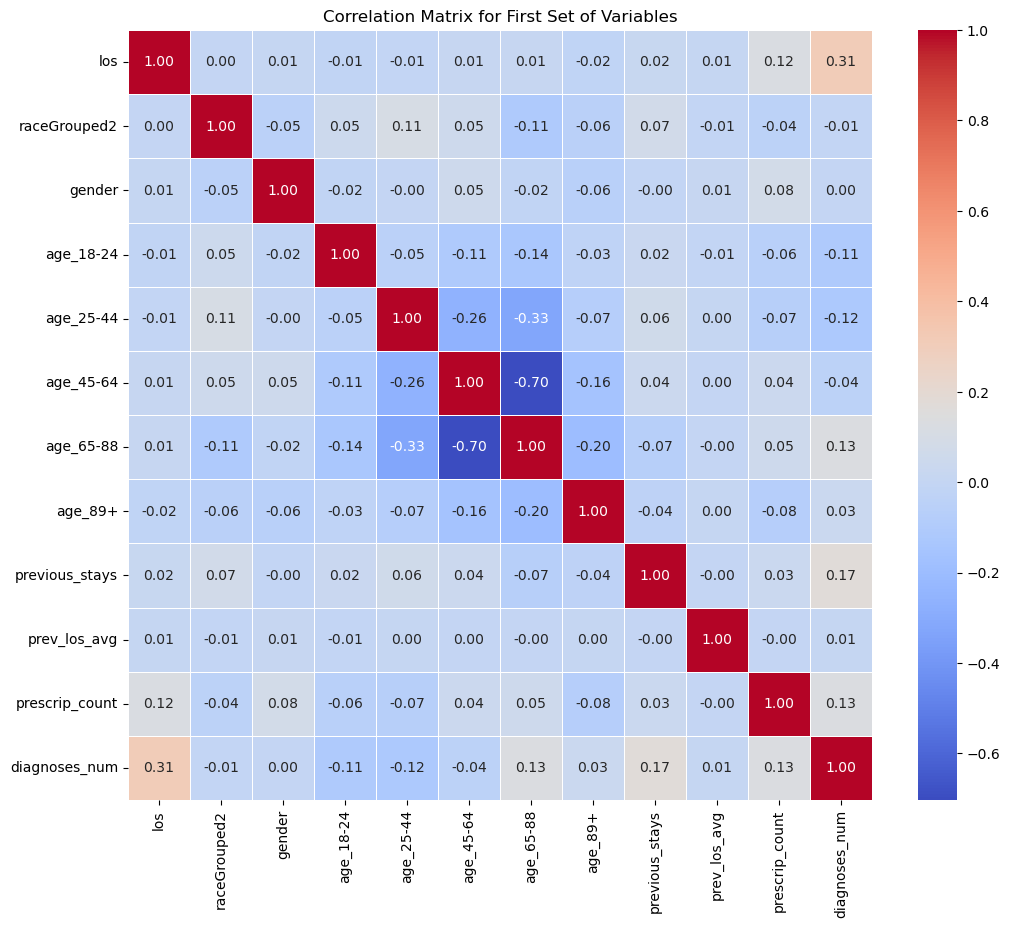

In [ ]:
# corr matrices first non lab
first_set_variables = ['los', 'raceGrouped2', 'gender',
                       'age_18-24', 'age_25-44', 'age_45-64', 'age_65-88',
                       'age_89+', 'previous_stays', 'prev_los_avg',
                       'prescrip_count', 'diagnoses_num']

first_set_data = merged[first_set_variables]
corr_matrix_first_set = first_set_data.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix_first_set, annot=True, fmt=".2f", cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix for First Set of Variables')
plt.show()


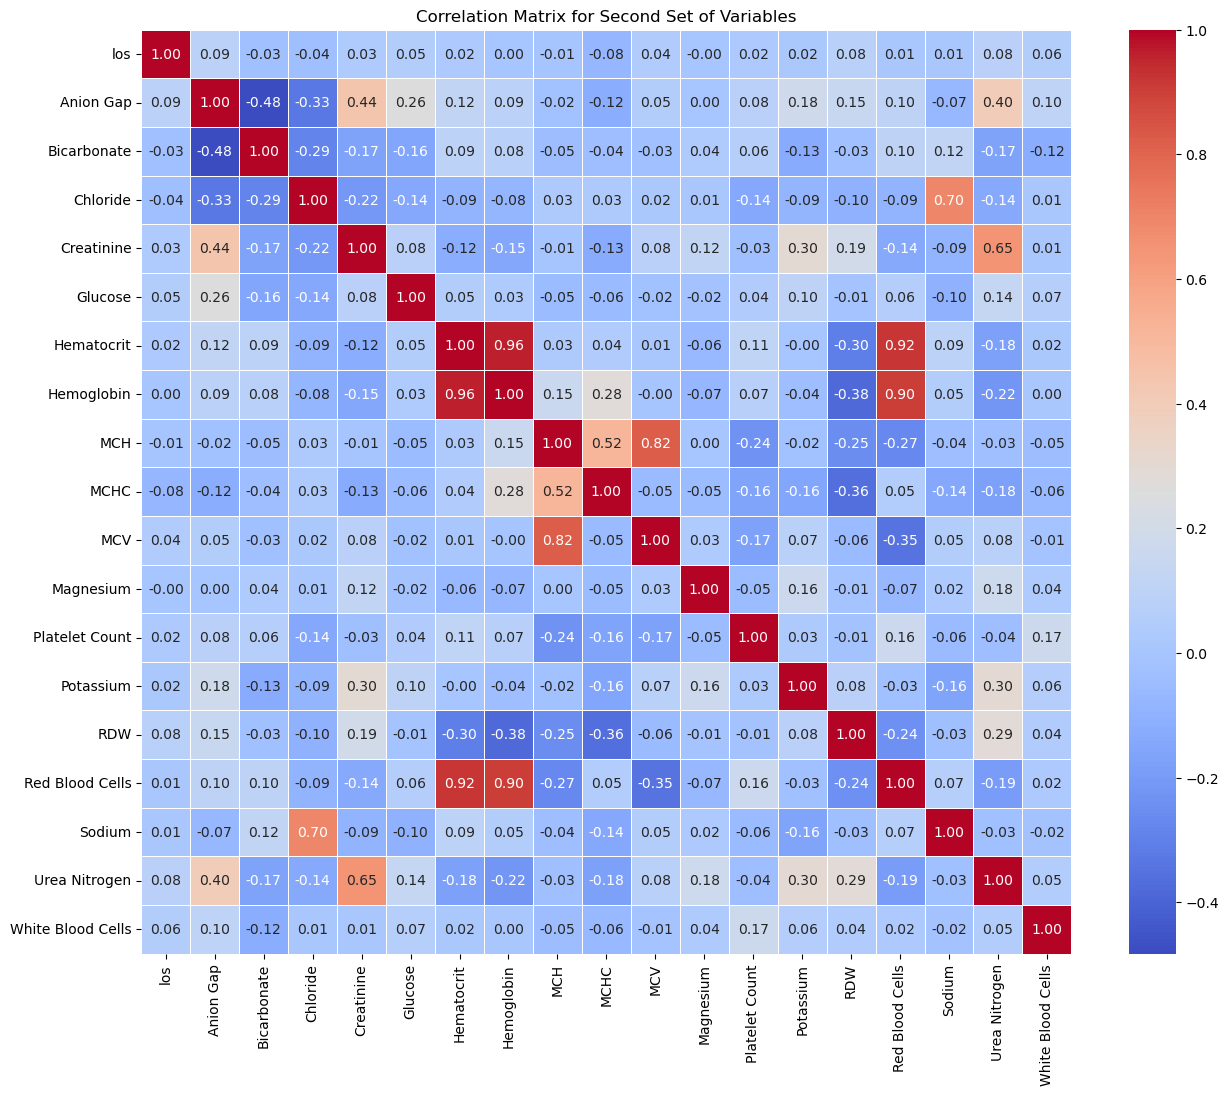

In [ ]:
# corr matrix w lab values
second_set_variables = ['los', 'Anion Gap', 'Bicarbonate', 'Chloride',
                        'Creatinine', 'Glucose', 'Hematocrit', 'Hemoglobin',
                        'MCH', 'MCHC', 'MCV', 'Magnesium', 'Platelet Count',
                        'Potassium', 'RDW', 'Red Blood Cells', 'Sodium',
                        'Urea Nitrogen', 'White Blood Cells']

second_set_data = merged[second_set_variables]
corr_matrix_second_set = second_set_data.corr()

plt.figure(figsize=(15, 12))
sns.heatmap(corr_matrix_second_set, annot=True, fmt=".2f", cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix for Second Set of Variables')
plt.show()


In [ ]:
merged['los'].describe()

count    41413.000000
mean         3.530498
std          3.322124
min          1.000000
25%          1.538576
50%          2.283160
75%          4.039097
max         21.987106
Name: los, dtype: float64

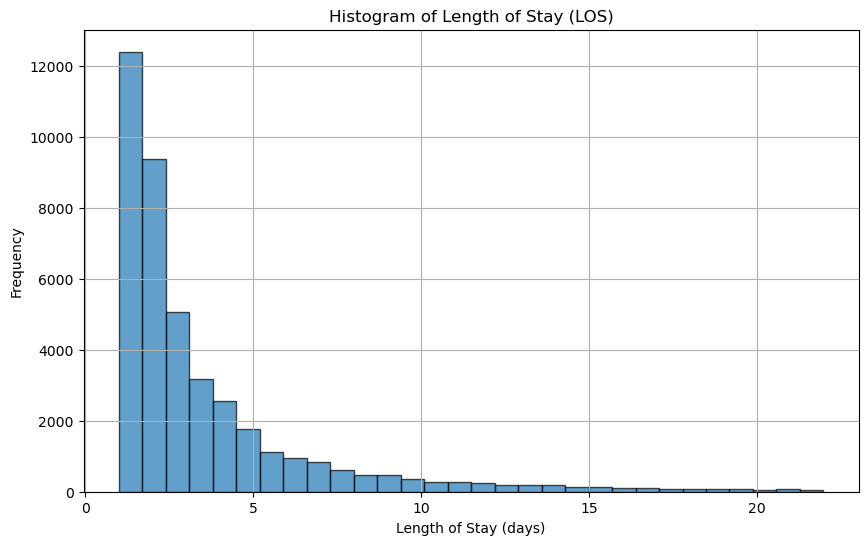

Boundary of bin 4: 3.7982808641975305
Sum of the frequencies of the first 4 bins: 29969.0
Sum of the frequencies of the remaining bins: 11444.0


In [ ]:
plt.figure(figsize=(10, 6))
n, bins, _ = plt.hist(merged['los'], bins=30, edgecolor='k', alpha=0.7)
plt.title('Histogram of Length of Stay (LOS)')
plt.xlabel('Length of Stay (days)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

first_4_bins_sum = n[:4].sum()
remains = n[4:].sum()

print(f"Boundary of bin 4: {bins[4]}")

print(f"Sum of the frequencies of the first 4 bins: {first_4_bins_sum}")
print(f"Sum of the frequencies of the remaining bins: {remains}")

## make dummies

In [ ]:
columns_to_encode = ['admission_location', 'insurance', 'marital_status', 'raceGrouped']

# acronyms for the prefixes
prefixes = {
    'admission_location': 'ADM',
    'insurance': 'INS',
    'marital_status': 'MS',
    'raceGrouped': 'RACE',
}

dummy_variables = pd.get_dummies(merged[columns_to_encode], prefix=prefixes)
merged = pd.concat([merged, dummy_variables], axis=1)
merged = merged.drop(columns=columns_to_encode)

merged.head()


,subject_id,hadm_id,stay_id,intime,outtime,los,raceGrouped2,gender,age_18-24,age_25-44,...,INS_Other,MS_DIVORCED,MS_MARRIED,MS_SINGLE,MS_WIDOWED,RACE_Asian,RACE_Black/African American,RACE_Hispanic/Latino,RACE_Other,RACE_White
0,10001217,24597018,37067082,2157-11-20 19:18:02,2157-11-21 22:08:00,1.118032,0,0,0,0,...,1,0,1,0,0,0,0,0,0,1
1,10001725,25563031,31205490,2110-04-11 15:52:22,2110-04-12 23:59:56,1.338588,0,0,0,0,...,1,0,1,0,0,0,0,0,0,1
2,10001884,26184834,37510196,2131-01-11 04:20:05,2131-01-20 08:27:30,9.171817,1,0,0,0,...,0,0,1,0,0,0,1,0,0,0
3,10002013,23581541,39060235,2160-05-18 10:00:53,2160-05-19 17:33:33,1.314352,1,0,0,0,...,0,0,0,1,0,0,0,0,1,0
4,10002155,23822395,33685454,2129-08-04 12:45:00,2129-08-10 17:02:38,6.178912,0,0,0,0,...,1,0,1,0,0,0,0,0,0,1


In [ ]:
df = merged.copy()

columns_to_drop = ['subject_id', 'hadm_id', 'stay_id', 'intime', 'outtime']
merged = merged.drop(columns=columns_to_drop)

In [ ]:
# # filtered_columns = corr_with_los[(corr_with_los > 0.05) | (corr_with_los < -0.05)]

# # Drop columns with small correlations
# # merged = merged.drop(columns=filtered_columns.index)
# filtered_columns = corr_with_los[(corr_with_los > 0.05) | (corr_with_los < -0.05)]
# columns_to_keep = filtered_columns.index
# merged = merged[columns_to_keep]

# # Print the columns that are kept
# print("Columns kept:", list(columns_to_keep))

# merged.shape

# filtered_columns

Columns kept: ['los', '0.83% Sodium Chloride', '0.9% Sodium Chloride', '0.9% Sodium Chloride (Mini Bag Plus)', '5% Dextrose', '5% Dextrose (EXCEL BAG)', 'AcetaZOLamide Sodium', 'Acetaminophen (Liquid)', 'Acetylcysteine 20%', 'Albumin 25% (12.5g / 50mL)', 'Albumin 5%', 'Albumin 5% ', 'Albumin 5% (12.5g / 250mL)', 'Albuterol Inhaler', 'Alteplase (Catheter Clearance)', 'Amiodarone', 'Artificial Tear Ointment', 'Artificial Tears', 'Artificial Tears GEL 1%', 'Aspirin EC', 'Azithromycin ', 'Bag', 'Bisacodyl', 'Calcium Chloride', 'Calcium Gluconate', 'CefTAZidime', 'CefePIME', 'Chlorhexidine Gluconate 0.12% Oral Rinse', 'Chlorothiazide Sodium', 'Ciprofloxacin IV', 'Cisatracurium Besylate', 'Citrate Dextrose 3% (ACD-A) CRRT', 'DOBUTamine', 'DOPamine', 'Dexmedetomidine', 'EPINEPHrine', 'Epoprostenol (Veletri)', 'Etomidate', 'Famotidine', 'Fentanyl Citrate', 'Fluconazole', 'Furosemide', 'Gastroview (Diatrizoate Meglumine & Sodium)', 'Glycopyrrolate', 'Haloperidol', 'Heparin', 'Heparin (CRRT Mach

(49833, 131)

In [ ]:
# # we are still going to keep 'gender', 'raceGrouped', 'INS_Medicaid', 'INS_Medicare' and 'INS_Other' to assess bias
# # we will just ignore these since the correlation is very very small
# merged[['gender', 'RACE_Asian', 'RACE_Black/African American', 'RACE_Hispanic/Latino', 'RACE_Other', 'RACE_White', 'INS_Medicaid', 'INS_Medicare', 'INS_Other', 'age_18-24', 'age_25-44', 'age_45-64', 'age_65-88','age_89+']] = df[['gender', 'RACE_Asian', 'RACE_Black/African American', 'RACE_Hispanic/Latino', 'RACE_Other', 'RACE_White', 'INS_Medicaid', 'INS_Medicare', 'INS_Other', 'age_18-24', 'age_25-44', 'age_45-64', 'age_65-88','age_89+']]

In [ ]:
df_filtered = df.copy()

In [ ]:
merged['los'].describe()

count    41413.000000
mean         3.530498
std          3.322124
min          1.000000
25%          1.538576
50%          2.283160
75%          4.039097
max         21.987106
Name: los, dtype: float64

In [ ]:
print(len(merged[merged['los'] < 2.283160]))
print(len(merged[merged['los'] > 2.283160]))

20707
20706


# Modelling

In [ ]:
df_filtered.shape

(41413, 51)

In [ ]:
# make binary 'los'
df_filtered['los_category'] = np.where(df_filtered['los'] > 3, 'long', 'short')

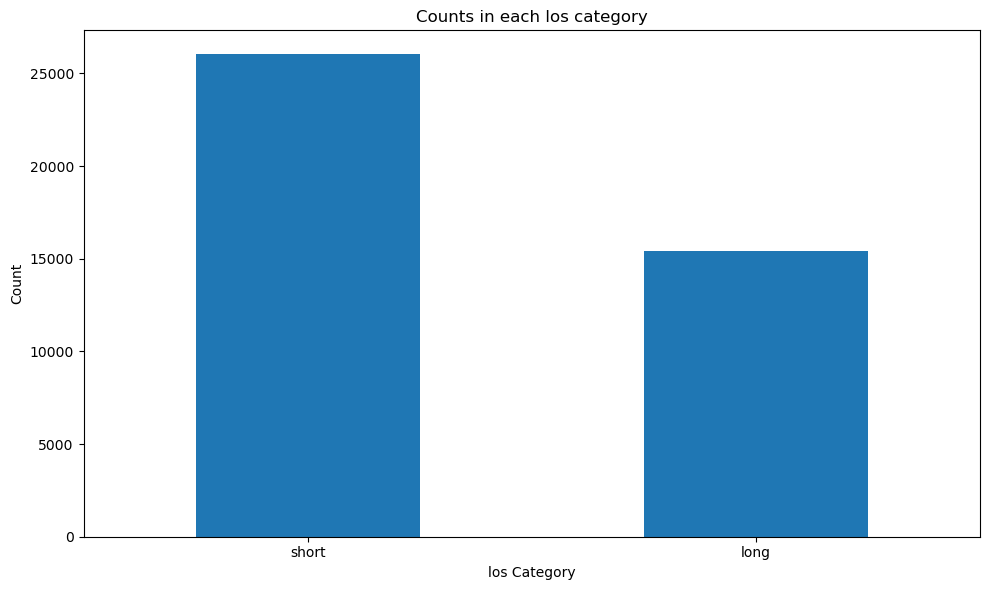

In [ ]:
los_counts = df_filtered['los_category'].value_counts()

plt.figure(figsize=(10, 6))
los_counts.plot(kind='bar')
plt.title('Counts in each los category')
plt.xlabel('los Category')
plt.ylabel('Count')
plt.xticks(rotation=360)
plt.tight_layout()
plt.show()

In [ ]:
df_filtered['los_category'].value_counts()

short    26020
long     15393
Name: los_category, dtype: int64

In [ ]:
df_filtered.columns

Index(['subject_id', 'hadm_id', 'stay_id', 'intime', 'outtime', 'los',
       'raceGrouped2', 'gender', 'age_18-24', 'age_25-44', 'age_45-64',
       'age_65-88', 'age_89+', 'previous_stays', 'prev_los_avg', 'Anion Gap',
       'Bicarbonate', 'Chloride', 'Creatinine', 'Glucose', 'Hematocrit',
       'Hemoglobin', 'MCH', 'MCHC', 'MCV', 'Magnesium', 'Platelet Count',
       'Potassium', 'RDW', 'Red Blood Cells', 'Sodium', 'Urea Nitrogen',
       'White Blood Cells', 'prescrip_count', 'diagnoses_num', 'ADM_Emergency',
       'ADM_Other', 'ADM_Referral', 'ADM_Transfer', 'INS_Medicaid',
       'INS_Medicare', 'INS_Other', 'MS_DIVORCED', 'MS_MARRIED', 'MS_SINGLE',
       'MS_WIDOWED', 'RACE_Asian', 'RACE_Black/African American',
       'RACE_Hispanic/Latino', 'RACE_Other', 'RACE_White', 'los_category'],
      dtype='object')

In [ ]:
# Count plot to show the distribution of long and short stays by gender
plt.figure(figsize=(10, 6))
sns.countplot(data=df_filtered, x='los_category', hue='gender', palette='Set2')
plt.title('Distribution of Length of Stay Categories by Gender')
plt.xlabel('Length of Stay Category')
plt.ylabel('Count')
plt.legend(title='Gender', labels=['Male', 'Female'])
plt.show()




NameError: name 'plt' is not defined

In [ ]:
df_filtered['gender'].value_counts()

1    22967
0    18446
Name: gender, dtype: int64

## XGBoost: binary

In [ ]:
df_filtered

,los,raceGrouped2,gender,age_18-24,age_25-44,age_45-64,age_65-88,age_89+,previous_stays,prev_los_avg,...,MS_DIVORCED,MS_MARRIED,MS_SINGLE,MS_WIDOWED,RACE_Asian,RACE_Black/African American,RACE_Hispanic/Latino,RACE_Other,RACE_White,los_category
0,1.118032,0,0,0,0,1,0,0,0,0.000000,...,0,1,0,0,0,0,0,0,1,short
1,1.338588,0,0,0,0,1,0,0,0,0.000000,...,0,1,0,0,0,0,0,0,1,short
2,9.171817,1,0,0,0,0,1,0,0,0.000000,...,0,1,0,0,0,1,0,0,0,long
3,1.314352,1,0,0,0,1,0,0,0,0.000000,...,0,0,1,0,0,0,0,1,0,short
4,6.178912,0,0,0,0,0,1,0,0,0.000000,...,0,1,0,0,0,0,0,0,1,long
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41408,4.705752,1,0,0,0,0,1,0,1,4.606411,...,0,0,1,0,0,1,0,0,0,long
41409,7.023715,1,1,0,1,0,0,0,0,4.606411,...,0,0,1,0,0,0,0,1,0,long
41410,6.950370,0,1,0,1,0,0,0,0,4.606411,...,1,0,0,0,0,0,0,0,1,long
41411,1.790995,0,0,0,0,1,0,0,0,4.606411,...,0,0,1,0,0,0,0,0,1,short


In [ ]:
import xgboost as xgb
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder

from imblearn.over_sampling import SMOTE

In [ ]:
df_filtered = pd.read_csv('/content/sample_data/final.csv')

In [ ]:
X = df_filtered.drop(columns=['los_category'])
y = df_filtered['los_category']

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Define the list of protected attributes
protected_attributes = ['gender', 'RACE_Asian', 'RACE_Black/African American',
                        'RACE_Hispanic/Latino', 'RACE_Other', 'RACE_White', 'age_18-24',
                        'age_25-44', 'age_45-64', 'age_65-88', 'INS_Medicaid', 'INS_Medicare', 'INS_Other']


# Calculate the count of instances for each category in the training set
for attribute in protected_attributes:
    if attribute == 'gender':
        counts = X_train[attribute].value_counts()
        print(f"{attribute}:")
        print(counts)
        print()
    else:
        counts = X_train[attribute].value_counts()
        print(f"{attribute}:")
        print(counts[1])
        print()


gender:
gender
1    18413
0    14717
Name: count, dtype: int64

RACE_Asian:
1086

RACE_Black/African American:
3911

RACE_Hispanic/Latino:
1358

RACE_Other:
1681

RACE_White:
8036

age_18-24:
658

age_25-44:
3593

age_45-64:
11937

age_65-88:
15477

INS_Medicaid:
2332

INS_Medicare:
15361

INS_Other:
15437



In [ ]:
sample = df_filtered

features = ['gender', 'RACE_Asian', 'RACE_Black/African American',
            'RACE_Hispanic/Latino', 'RACE_Other', 'RACE_White', 'age_18-24',
            'age_25-44', 'age_45-64', 'age_65-88',
            'age_89+', 'previous_stays', 'prev_los_avg', 'Anion Gap',
            'Bicarbonate', 'Chloride', 'Creatinine', 'Glucose', 'Hematocrit',
            'Hemoglobin', 'MCH', 'MCHC', 'MCV', 'Magnesium', 'Platelet Count',
            'Potassium', 'RDW', 'Red Blood Cells', 'Sodium', 'Urea Nitrogen',
            'White Blood Cells', 'prescrip_count', 'diagnoses_num',
            'ADM_Emergency', 'ADM_Other', 'ADM_Referral', 'ADM_Transfer',
            'INS_Medicaid', 'INS_Medicare', 'INS_Other']


X = df_filtered[features]
y = df_filtered['los_category']

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# from imblearn.under_sampling import RandomUnderSampler
# from sklearn.model_selection import train_test_split

# # Splitting the data
# X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# # Applying Random Under-Sampling
# rus = RandomUnderSampler(random_state=42)
# X_train_resampled, y_train_resampled = rus.fit_resample(X_train, y_train)



In [ ]:
# Oversampling technique:
# SMOTE (Synthetic Minority Over-sampling Technique) balances the class distribution by generating synthetic examples for the minority class

In [ ]:
# SMOTE for oversampling
# smote = SMOTE(random_state=42)
# X_resampled, y_resampled = smote.fit_resample(X, y_encoded)

# X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

xgb_model = xgb.XGBClassifier()

# Update the parameter grid to include scale_pos_weight
param_grid = {
    'n_estimators': [100, 200, 500],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 4, 5],
    'colsample_bytree': [0.6, 0.7, 0.8]
}

grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    scoring='accuracy',
    cv=3,
    verbose=2,
    n_jobs=-1
)

# grid_search.fit(X_train, y_train)
# print(f"Best parameters found: {grid_search.best_params_}")

# # Perform the grid search on the training data
grid_search.fit(X_train_resampled, y_train_resampled)
print(f"Best parameters found: {grid_search.best_params_}")

# # Training using the the best model
best_xgb_model = grid_search.best_estimator_
best_xgb_model.fit(X_train_resampled, y_train_resampled)
y_pred_xgb = best_xgb_model.predict(X_test)


# best_xgb_model.fit(X_train, y_train)
# y_pred_xgb = best_xgb_model.predict(X_test)


# evaluation metrics
accuracy = accuracy_score(y_test, y_pred_xgb)
print("Overall Accuracy of XGBoost Classifier:", accuracy)

conf_matrix = confusion_matrix(y_test, y_pred_xgb)
print("Overall Confusion Matrix:")
print(conf_matrix)

y_test_labels = label_encoder.inverse_transform(y_test)
y_pred_labels = label_encoder.inverse_transform(y_pred_xgb)

class_report_labels = classification_report(y_test_labels, y_pred_labels)

print("Overall Classification Report:")
print(class_report_labels)


Fitting 3 folds for each of 81 candidates, totalling 243 fits
Best parameters found: {'colsample_bytree': 0.7, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 500}
Overall Accuracy of XGBoost Classifier: 0.6660630206446939
Overall Confusion Matrix:
[[1191 1853]
 [ 913 4326]]
Overall Classification Report:
              precision    recall  f1-score   support

        long       0.57      0.39      0.46      3044
       short       0.70      0.83      0.76      5239

    accuracy                           0.67      8283
   macro avg       0.63      0.61      0.61      8283
weighted avg       0.65      0.67      0.65      8283



Overall Accuracy of XGBoost Classifier: 0.793718772305496
Overall Confusion Matrix:
[[506 178]
 [111 606]]
Overall Classification Report:
              precision    recall  f1-score   support

        long       0.82      0.74      0.78       684
       short       0.77      0.85      0.81       717

    accuracy                           0.79      1401
   macro avg       0.80      0.79      0.79      1401
weighted avg       0.80      0.79      0.79      1401





In [ ]:
def evaluate_subgroup(subgroup_name, subgroup_value):
    subgroup_indices = X_test[subgroup_name] == subgroup_value
    subgroup_X_test = X_test[subgroup_indices]
    subgroup_y_test = y_test[subgroup_indices]
    subgroup_y_pred = y_pred_xgb[subgroup_indices]

    accuracy = accuracy_score(subgroup_y_test, subgroup_y_pred)
    print(f"Accuracy for {subgroup_name}={subgroup_value}: {accuracy}")

    conf_matrix = confusion_matrix(subgroup_y_test, subgroup_y_pred)
    print(f"Confusion Matrix for {subgroup_name}={subgroup_value}:")
    print(conf_matrix)

    subgroup_y_test_labels = label_encoder.inverse_transform(subgroup_y_test)
    subgroup_y_pred_labels = label_encoder.inverse_transform(subgroup_y_pred)
    class_report = classification_report(subgroup_y_test_labels, subgroup_y_pred_labels)
    print(f"Classification Report for {subgroup_name}={subgroup_value}:")
    print(class_report)

# gender
print("MALE")
evaluate_subgroup('gender', 0)
print("\nFEMALE")
evaluate_subgroup('gender', 1)

MALE
Accuracy for gender=0: 0.6765888978278359
Confusion Matrix for gender=0:
[[ 551  806]
 [ 400 1972]]
Classification Report for gender=0:
              precision    recall  f1-score   support

        long       0.58      0.41      0.48      1357
       short       0.71      0.83      0.77      2372

    accuracy                           0.68      3729
   macro avg       0.64      0.62      0.62      3729
weighted avg       0.66      0.68      0.66      3729


FEMALE
Accuracy for gender=1: 0.6668862538427756
Confusion Matrix for gender=1:
[[ 652 1035]
 [ 482 2385]]
Classification Report for gender=1:
              precision    recall  f1-score   support

        long       0.57      0.39      0.46      1687
       short       0.70      0.83      0.76      2867

    accuracy                           0.67      4554
   macro avg       0.64      0.61      0.61      4554
weighted avg       0.65      0.67      0.65      4554



- ACCURACY: Males have a higher accuracy than females (81.14% vs. 77.19%)
- RECALL: Males have a higher recall for long stays compared to females (80% vs. 63%). --> better at correctly identifying long stays for males compared to females
Females have a higher recall for short stays compared to males (87% vs. 82%) --> better at correctly identifying short stays for females


In [ ]:
# #  race groups: White/minority
# print("\nWHITE")
# evaluate_subgroup('raceGrouped2', 0)
# print("\nMINORITY")
# evaluate_subgroup('raceGrouped2', 1)


# race categories
print("\nASIAN")
evaluate_subgroup('RACE_Asian', 1)
print("\nBLACK/AFRICAN AMERICAN")
evaluate_subgroup('RACE_Black/African American', 1)
print("\nHISPANIC/LATINO")
evaluate_subgroup('RACE_Hispanic/Latino', 1)
print("\nOTHER RACE")
evaluate_subgroup('RACE_Other', 1)
print("\nWHITE")
evaluate_subgroup('RACE_White', 1)



ASIAN
Accuracy for RACE_Asian=1: 0.6877192982456141
Confusion Matrix for RACE_Asian=1:
[[ 43  64]
 [ 25 153]]
Classification Report for RACE_Asian=1:
              precision    recall  f1-score   support

        long       0.63      0.40      0.49       107
       short       0.71      0.86      0.77       178

    accuracy                           0.69       285
   macro avg       0.67      0.63      0.63       285
weighted avg       0.68      0.69      0.67       285


BLACK/AFRICAN AMERICAN
Accuracy for RACE_Black/African American=1: 0.6812182741116751
Confusion Matrix for RACE_Black/African American=1:
[[129 216]
 [ 98 542]]
Classification Report for RACE_Black/African American=1:
              precision    recall  f1-score   support

        long       0.57      0.37      0.45       345
       short       0.72      0.85      0.78       640

    accuracy                           0.68       985
   macro avg       0.64      0.61      0.61       985
weighted avg       0.66      0.

- RACE_Asian                      178: 0.46511627906976744
- RACE_Black/African American     592: 0.6239316239316239
- RACE_Hispanic/Latino            218: 0.6875
- RACE_Other                      267:  0.5833333333333334
- RACE_White                     3745: 0.6102150537634409

- White highest overall accuracy
- precision for long stays is very low for Hispanic/Latino (40%) & Black/African American (43%) and best for white race(0.79%)
-----> limitations in predicting long stays for individuals in the Asian, Black/African American, Hispanic/Latino, and Other Race categories

In [ ]:
#  age groups
print("\nAGE 18-24")
evaluate_subgroup('age_18-24', 1)
print("\nAGE 25-44")
evaluate_subgroup('age_25-44', 1)
print("\nAGE 45-64")
evaluate_subgroup('age_45-64', 1)
print("\nAGE 65-88")
evaluate_subgroup('age_65-88', 1)
print("\nAGE 89+")
evaluate_subgroup('age_89+', 1)


AGE 18-24
Accuracy for age_18-24=1: 0.7287234042553191
Confusion Matrix for age_18-24=1:
[[ 18  31]
 [ 20 119]]
Classification Report for age_18-24=1:
              precision    recall  f1-score   support

           0       0.47      0.37      0.41        49
           1       0.79      0.86      0.82       139

    accuracy                           0.73       188
   macro avg       0.63      0.61      0.62       188
weighted avg       0.71      0.73      0.72       188


AGE 25-44
Accuracy for age_25-44=1: 0.6886574074074074
Confusion Matrix for age_25-44=1:
[[100 178]
 [ 91 495]]
Classification Report for age_25-44=1:
              precision    recall  f1-score   support

           0       0.52      0.36      0.43       278
           1       0.74      0.84      0.79       586

    accuracy                           0.69       864
   macro avg       0.63      0.60      0.61       864
weighted avg       0.67      0.69      0.67       864


AGE 45-64
Accuracy for age_45-64=1: 0.687

- limitations in predicting long stays, particularly for younger (18-24 and 25-44) and older (89+) age groups

In [ ]:
# insurance types
print("\nMEDICAID")
evaluate_subgroup('INS_Medicaid', 1)
print("\nMEDICARE")
evaluate_subgroup('INS_Medicare', 1)
print("\nOTHER INSURANCE")
evaluate_subgroup('INS_Other', 1)


MEDICAID
Accuracy for INS_Medicaid=1: 0.6962233169129721
Confusion Matrix for INS_Medicaid=1:
[[ 81 134]
 [ 51 343]]
Classification Report for INS_Medicaid=1:
              precision    recall  f1-score   support

           0       0.61      0.38      0.47       215
           1       0.72      0.87      0.79       394

    accuracy                           0.70       609
   macro avg       0.67      0.62      0.63       609
weighted avg       0.68      0.70      0.67       609


MEDICARE
Accuracy for INS_Medicare=1: 0.6471956577927113
Confusion Matrix for INS_Medicare=1:
[[ 604  890]
 [ 475 1900]]
Classification Report for INS_Medicare=1:
              precision    recall  f1-score   support

           0       0.56      0.40      0.47      1494
           1       0.68      0.80      0.74      2375

    accuracy                           0.65      3869
   macro avg       0.62      0.60      0.60      3869
weighted avg       0.63      0.65      0.63      3869


OTHER INSURANCE
Accur

--> no major differneces, only in medicaid bc there is not much data

# Removing protected attributes

In [ ]:
def calculate_protected_attribute_metrics(results, protected_attribute):
    if protected_attribute == 'gender':
        unique_values = results[protected_attribute].unique()
        for value in unique_values:
            subset = results[results[protected_attribute] == value]
            y_test_subset = subset['y_test']
            y_pred_subset = subset['y_pred']

            # Accuracy
            accuracy = accuracy_score(y_test_subset, y_pred_subset)

            # Confusion Matrix
            conf_matrix = confusion_matrix(y_test_subset, y_pred_subset)

            # Classification Report
            y_test_labels = label_encoder.inverse_transform(y_test_subset)
            y_pred_labels = label_encoder.inverse_transform(y_pred_subset)
            class_report = classification_report(y_test_labels, y_pred_labels)

            gender_label = 'Female' if value == 1 else 'Male'
            print(f"Metrics for {protected_attribute} = {gender_label}:")
            print(f"Overall Accuracy of XGBoost Classifier: {accuracy}")
            print("Overall Confusion Matrix:")
            print(conf_matrix)
            print("Overall Classification Report:")
            print(class_report)
            print("\n")
    else:
        subset = results[results[protected_attribute] == 1]
        y_test_subset = subset['y_test']
        y_pred_subset = subset['y_pred']

        # Accuracy
        accuracy = accuracy_score(y_test_subset, y_pred_subset)

        # Confusion Matrix
        conf_matrix = confusion_matrix(y_test_subset, y_pred_subset)

        # Classification Report
        y_test_labels = label_encoder.inverse_transform(y_test_subset)
        y_pred_labels = label_encoder.inverse_transform(y_pred_subset)
        class_report = classification_report(y_test_labels, y_pred_labels)

        print(f"Metrics for {protected_attribute} = 1:")
        print(f"Overall Accuracy of XGBoost Classifier: {accuracy}")
        print("Overall Confusion Matrix:")
        print(conf_matrix)
        print("Overall Classification Report:")
        print(class_report)
        print("\n")


protected_attributes = ['gender', 'RACE_Asian', 'RACE_Black/African American',
                 'RACE_Hispanic/Latino', 'RACE_Other', 'RACE_White', 'age_18-24',
                 'age_25-44', 'age_45-64', 'age_65-88', 'age_89+', 'INS_Medicaid', 'INS_Medicare', 'INS_Other']

X_test_with_protected = df_filtered.loc[X_test.index][protected_attributes].reset_index(drop=True)
results = pd.DataFrame({'y_test': y_test, 'y_pred': y_pred_xgb})
results = results.join(X_test_with_protected)

for protected_attribute in protected_attributes:
    calculate_protected_attribute_metrics(results, protected_attribute)


Metrics for gender = Female:
Overall Accuracy of XGBoost Classifier: 0.663372859025033
Overall Confusion Matrix:
[[ 666 1021]
 [ 512 2355]]
Overall Classification Report:
              precision    recall  f1-score   support

        long       0.57      0.39      0.46      1687
       short       0.70      0.82      0.75      2867

    accuracy                           0.66      4554
   macro avg       0.63      0.61      0.61      4554
weighted avg       0.65      0.66      0.65      4554



Metrics for gender = Male:
Overall Accuracy of XGBoost Classifier: 0.6650576562080986
Overall Confusion Matrix:
[[ 514  843]
 [ 406 1966]]
Overall Classification Report:
              precision    recall  f1-score   support

        long       0.56      0.38      0.45      1357
       short       0.70      0.83      0.76      2372

    accuracy                           0.67      3729
   macro avg       0.63      0.60      0.61      3729
weighted avg       0.65      0.67      0.65      3729



M

# Bias Mitigation

## Pre-processing Technique: weighting

Code inspo from: https://github.com/Trusted-AI/AIF360/blob/main/examples/demo_reweighing_preproc.ipynb

--> think of baseline model

--> trade off fairness and performance

In [ ]:
train_features = ['previous_stays', 'prev_los_avg', 'Anion Gap',
                  'Bicarbonate', 'Chloride', 'Creatinine', 'Glucose', 'Hematocrit',
                  'Hemoglobin', 'MCH', 'MCHC', 'MCV', 'Magnesium', 'Platelet Count',
                  'Potassium', 'RDW', 'Red Blood Cells', 'Sodium', 'Urea Nitrogen',
                  'White Blood Cells', 'prescrip_count', 'diagnoses_num',
                  'ADM_Emergency', 'ADM_Other', 'ADM_Referral', 'ADM_Transfer',
                  'gender', 'RACE_Asian', 'RACE_Black/African American',
                  'RACE_Hispanic/Latino', 'RACE_Other', 'RACE_White', 'age_18-24',
                  'age_25-44', 'age_45-64', 'age_65-88', 'age_89+', 'INS_Medicaid', 'INS_Medicare', 'INS_Other']

# Define protected attributes
protected_attributes = ['gender', 'RACE_Asian', 'RACE_Black/African American',
                        'RACE_Hispanic/Latino', 'RACE_Other', 'RACE_White', 'age_18-24',
                        'age_25-44', 'age_45-64', 'age_65-88', 'age_89+', 'INS_Medicaid', 'INS_Medicare', 'INS_Other']


In [ ]:
unprivileged_groups = [{'RACE_Black/African American': 1}, {'RACE_Hispanic/Latino': 1}, {'RACE_Other': 1}, {'age_18-24': 1},
                       {'age_25-44': 1}, {'age_89+': 1},
                        {'INS_Medicare': 1}]

privileged_groups = [{'RACE_White': 1}, {'RACE_Asian': 1},
                     {'age_45-64': 1},{'age_65-88': 1},
                     {'INS_Other': 1}, {'INS_Medicaid': 1}]



df_filtered['los_category'] = df_filtered['los_category'].map({'long': 0, 'short': 1})

In [ ]:
from aif360.datasets import BinaryLabelDataset
from aif360.metrics import BinaryLabelDatasetMetric
from aif360.algorithms.preprocessing import Reweighing

X = df_filtered[train_features]
y = df_filtered['los_category']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Convert the training set into a BinaryLabelDataset
df_train = X_train.copy()
df_train['los_category'] = y_train


binary_label_dataset_train = BinaryLabelDataset(
    df=df_train,
    label_names=['los_category'],
    protected_attribute_names=protected_attributes
)


pip install 'aif360[Reductions]'
pip install 'aif360[Reductions]'
pip install 'aif360[inFairness]'
pip install 'aif360[Reductions]'


In [ ]:
# reweighing algorithm
RW = Reweighing(unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups)

# reweighing on training set
train_rw = RW.fit_transform(binary_label_dataset_train)

# Extract reweighted training data
df_train_rw = train_rw.convert_to_dataframe()[0]
X_train_rw = df_train_rw[train_features]
y_train_rw = df_train_rw['los_category']

# SMOTE to handle 'los' imbalance in reweighted training set
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_rw, y_train_rw)

In [ ]:
from xgboost import XGBClassifier

# Train with reweighted training data
xgb_model = XGBClassifier()

param_grid = {
    'n_estimators': [100, 200, 500],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 4, 5],
    'colsample_bytree': [0.6, 0.7, 0.8]
}

grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    scoring='accuracy',
    cv=3,
    verbose=2,
    n_jobs=-1
)

# Perform the grid search on the training data
grid_search.fit(X_train_resampled, y_train_resampled)
print(f"Best parameters found: {grid_search.best_params_}")

# Training using the the best model
best_xgb_model = grid_search.best_estimator_
best_xgb_model.fit(X_train_resampled, y_train_resampled)
y_pred_xgb = best_xgb_model.predict(X_test)

# evaluation metrics
accuracy = accuracy_score(y_test, y_pred_xgb)
print("Overall Accuracy of XGBoost Classifier:", accuracy)

conf_matrix = confusion_matrix(y_test, y_pred_xgb)
print("Overall Confusion Matrix:")
print(conf_matrix)

y_test_labels = label_encoder.inverse_transform(y_test)
y_pred_labels = label_encoder.inverse_transform(y_pred_xgb)

class_report_labels = classification_report(y_test_labels, y_pred_labels)

print("Overall Classification Report:")
print(class_report_labels)

Fitting 3 folds for each of 81 candidates, totalling 243 fits


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


Best parameters found: {'colsample_bytree': 0.6, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 500}
Overall Accuracy of XGBoost Classifier: 0.6717372932512374
Overall Confusion Matrix:
[[1185 1859]
 [ 860 4379]]
Overall Classification Report:
              precision    recall  f1-score   support

        long       0.58      0.39      0.47      3044
       short       0.70      0.84      0.76      5239

    accuracy                           0.67      8283
   macro avg       0.64      0.61      0.61      8283
weighted avg       0.66      0.67      0.65      8283



**original predictions - no weighniting**

Overall Accuracy of XGBoost Classifier: 0.6712543764336593

Overall Confusion Matrix:

[[1203 1841]

 [ 882 4357]]

Overall Classification Report:

              precision    recall  f1-score   support

        long       0.58      0.40      0.47      3044
       short       0.70      0.83      0.76      5239

    accuracy                           0.67      8283

### Assessing across vars

In [ ]:
def evaluate_subgroup(subgroup_name, subgroup_value):
    subgroup_indices = X_test[subgroup_name] == subgroup_value
    subgroup_X_test = X_test[subgroup_indices]
    subgroup_y_test = y_test[subgroup_indices]
    subgroup_y_pred = y_pred_xgb[subgroup_indices]

    accuracy = accuracy_score(subgroup_y_test, subgroup_y_pred)
    print(f"Accuracy for {subgroup_name}={subgroup_value}: {accuracy}")

    conf_matrix = confusion_matrix(subgroup_y_test, subgroup_y_pred)
    print(f"Confusion Matrix for {subgroup_name}={subgroup_value}:")
    print(conf_matrix)

    subgroup_y_test_labels = label_encoder.inverse_transform(subgroup_y_test)
    subgroup_y_pred_labels = label_encoder.inverse_transform(subgroup_y_pred)
    class_report = classification_report(subgroup_y_test_labels, subgroup_y_pred_labels)
    print(f"Classification Report for {subgroup_name}={subgroup_value}:")
    print(class_report)

# gender
print("MALE")
evaluate_subgroup('gender', 0)
print("\nFEMALE")
evaluate_subgroup('gender', 1)


# model's performance is better for females in terms of overall accuracy (0.633 for females compared to 0.579 for males) and
# some individual metrics such as precision and recall for certain categories.

MALE
Accuracy for gender=0: 0.670957361222848
Confusion Matrix for gender=0:
[[ 514  843]
 [ 384 1988]]
Classification Report for gender=0:
              precision    recall  f1-score   support

        long       0.57      0.38      0.46      1357
       short       0.70      0.84      0.76      2372

    accuracy                           0.67      3729
   macro avg       0.64      0.61      0.61      3729
weighted avg       0.65      0.67      0.65      3729


FEMALE
Accuracy for gender=1: 0.6723759332454985
Confusion Matrix for gender=1:
[[ 671 1016]
 [ 476 2391]]
Classification Report for gender=1:
              precision    recall  f1-score   support

        long       0.59      0.40      0.47      1687
       short       0.70      0.83      0.76      2867

    accuracy                           0.67      4554
   macro avg       0.64      0.62      0.62      4554
weighted avg       0.66      0.67      0.66      4554



In [ ]:
# #  race groups: White/minority
# print("\nWHITE")
# evaluate_subgroup('raceGrouped2', 0)
# print("\nMINORITY")
# evaluate_subgroup('raceGrouped2', 1)


# race categories
print("\nASIAN")
evaluate_subgroup('RACE_Asian', 1)
print("\nBLACK/AFRICAN AMERICAN")
evaluate_subgroup('RACE_Black/African American', 1)
print("\nHISPANIC/LATINO")
evaluate_subgroup('RACE_Hispanic/Latino', 1)
print("\nOTHER RACE")
evaluate_subgroup('RACE_Other', 1)
print("\nWHITE")
evaluate_subgroup('RACE_White', 1)



ASIAN
Accuracy for RACE_Asian=1: 0.6947368421052632
Confusion Matrix for RACE_Asian=1:
[[ 42  65]
 [ 22 156]]
Classification Report for RACE_Asian=1:
              precision    recall  f1-score   support

        long       0.66      0.39      0.49       107
       short       0.71      0.88      0.78       178

    accuracy                           0.69       285
   macro avg       0.68      0.63      0.64       285
weighted avg       0.69      0.69      0.67       285


BLACK/AFRICAN AMERICAN
Accuracy for RACE_Black/African American=1: 0.6700507614213198
Confusion Matrix for RACE_Black/African American=1:
[[127 218]
 [107 533]]
Classification Report for RACE_Black/African American=1:
              precision    recall  f1-score   support

        long       0.54      0.37      0.44       345
       short       0.71      0.83      0.77       640

    accuracy                           0.67       985
   macro avg       0.63      0.60      0.60       985
weighted avg       0.65      0.

In [ ]:
#  age groups
print("\nAGE 18-24")
evaluate_subgroup('age_18-24', 1)
print("\nAGE 25-44")
evaluate_subgroup('age_25-44', 1)
print("\nAGE 45-64")
evaluate_subgroup('age_45-64', 1)
print("\nAGE 65-88")
evaluate_subgroup('age_65-88', 1)
print("\nAGE 89+")
evaluate_subgroup('age_89+', 1)


AGE 18-24
Accuracy for age_18-24=1: 0.7446808510638298
Confusion Matrix for age_18-24=1:
[[ 14  35]
 [ 13 126]]
Classification Report for age_18-24=1:
              precision    recall  f1-score   support

        long       0.52      0.29      0.37        49
       short       0.78      0.91      0.84       139

    accuracy                           0.74       188
   macro avg       0.65      0.60      0.60       188
weighted avg       0.71      0.74      0.72       188


AGE 25-44
Accuracy for age_25-44=1: 0.7106481481481481
Confusion Matrix for age_25-44=1:
[[ 96 182]
 [ 68 518]]
Classification Report for age_25-44=1:
              precision    recall  f1-score   support

        long       0.59      0.35      0.43       278
       short       0.74      0.88      0.81       586

    accuracy                           0.71       864
   macro avg       0.66      0.61      0.62       864
weighted avg       0.69      0.71      0.69       864


AGE 45-64
Accuracy for age_45-64=1: 0.690

In [ ]:
# insurance types
print("\nMEDICAID")
evaluate_subgroup('INS_Medicaid', 1)
print("\nMEDICARE")
evaluate_subgroup('INS_Medicare', 1)
print("\nOTHER INSURANCE")
evaluate_subgroup('INS_Other', 1)


MEDICAID
Accuracy for INS_Medicaid=1: 0.722495894909688
Confusion Matrix for INS_Medicaid=1:
[[ 79 136]
 [ 33 361]]
Classification Report for INS_Medicaid=1:
              precision    recall  f1-score   support

        long       0.71      0.37      0.48       215
       short       0.73      0.92      0.81       394

    accuracy                           0.72       609
   macro avg       0.72      0.64      0.65       609
weighted avg       0.72      0.72      0.69       609


MEDICARE
Accuracy for INS_Medicare=1: 0.6479710519514086
Confusion Matrix for INS_Medicare=1:
[[ 601  893]
 [ 469 1906]]
Classification Report for INS_Medicare=1:
              precision    recall  f1-score   support

        long       0.56      0.40      0.47      1494
       short       0.68      0.80      0.74      2375

    accuracy                           0.65      3869
   macro avg       0.62      0.60      0.60      3869
weighted avg       0.63      0.65      0.63      3869


OTHER INSURANCE
Accura